In [1]:
import torch
import gpytorch
import botorch
from botorch.models import SingleTaskMultiFidelityGP, SingleTaskGP
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll_torch
from torch.optim import Adam
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
import matplotlib.pyplot as plt
import HeBz

/home/sutirthapaul/miniconda3/envs/benzene/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_benzene(ax):
    c = HeBz.benzene()
    for i in range(6):
        ax.plot([c[i][1],c[i+6][1]],[c[i][2],c[i+6][2]],'o-',color='lavender')
    for j in range(6):
        ax.plot([c[j][1],c[(j+1) % 6][1]],[c[j][2],c[(j+1) % 6][2]],'o-',color='black')
    return True  

In [3]:
#Load the data from file
V = np.load('../data/HeBz/all_pts_2545.npy')
x = np.array([])
y = np.array([])
z = np.array([])
data_points = []
Pot = np.array([])
Pot_diff = np.array([])
for array in V:
    x = np.append(x,array[0])
    y = np.append(y,array[1])
    z = np.append(z,array[2])
    data_points.append([array[0],array[1],array[2],1.0])
    Pot = np.append(Pot,array[3])
"""
V2 = np.load('../data/new_pts_70.npy')
for array in V2:
    x = np.append(x,array[0])
    y = np.append(y,array[1])
    z = np.append(z,array[2])
    data_points.append([array[0],array[1],array[2],1.0])
    Pot = np.append(Pot,array[3]/0.695)
"""
data_points = np.array(data_points)
noise = 1e-6*np.ones_like(Pot)

In [4]:
# -----------------------------
# 1. Generate Source Task Data
# -----------------------------
DFTdata0 = np.load("../data/pbe0_113850_CP_D4_processed.npy")
ind = np.where(np.isclose(DFTdata0[:,2],0.09459459))
refdata = DFTdata0[ind]
refdata[:,2] = -1*refdata[:,2]
DFTdata = np.concatenate((DFTdata0,refdata))
ind = np.argsort(DFTdata[:,2], kind='stable')
DFTdatazsrt = DFTdata[ind]
ind = np.argsort(DFTdatazsrt[:,1], kind='stable')
DFTdatayzsrt = DFTdatazsrt[ind]
DFTdataxrem = DFTdatayzsrt[::200]
ind = np.argsort(DFTdataxrem[:,0], kind='stable')
DFTdataxremzsrt = DFTdataxrem[ind]
#DFTdata2 = np.load("pbe0_corr_sutirtha_CP_D4_full_processed.npy")
#DFTdatanew = np.concatenate((DFTdata2[:,0],DFTdata2[:,1],DFTdata2[:,2]),)
DFTdatazxrem = DFTdataxremzsrt
DFTdata2 = np.load("../data/pbe0_corr_sutirtha_CP_D4_full_processed.npy")
DFTtotal = np.concatenate((DFTdatazxrem[:,0:3],DFTdata2[:,0:3]))
data_source = [[x, y, z, w] for x, y, z, w in zip(DFTtotal[:,0],DFTtotal[:,1],DFTtotal[:,2],np.zeros(len(DFTtotal)))]
m_source = np.concatenate((DFTdatazxrem[:,-1],DFTdata2[:,-1]))
#DFTtotal = np.concatenate((DFTdatazxrem[:,0:4],DFTdata2[:,0:4]))
#np.concatenate(DFTdatazxrem,[[
#print(np.unique(DFTdataxremzsrt[:,2]))
#print(np.unique(DFTdatazxrem[:,2]))
#data_source = [[x, y, z, w] for x, y, z, w in zip(DFTdatazxrem[:,0],DFTdatazxrem[:,1],DFTdatazxrem[:,2],np.zeros(len(DFTdatazxrem)))]
#m_source = DFTdatazxrem[:,-1]
noise_source = 1e-6*np.ones_like(m_source)

In [5]:
#Identify a good cut
#print(np.unique(x))
#print(np.unique(DFTdata[DFTdata[:,0] > 4][:,0]))

In [6]:
#x = 4.34 is close enough in both sets, now we extract all the points.
CCSDT = data_points[np.where(np.isclose(x,4.34666622))]
CCSDT_p = Pot[np.where(np.isclose(x,4.34666622))]
#CCSDT = CCSDT0[np.where(np.isclose(CCSDT0[:,1],0))]
#CCSDT_p = CCSDT_p0[np.where(np.isclose(CCSDT0[:,1],0))]
#print(CCSDT)
DFT = DFTdata[np.where(np.isclose(DFTdata[:,0],4.34674799))]
#DFT = DFT0[np.where(np.isclose(DFT0[:,1],0))]
#print(DFT)

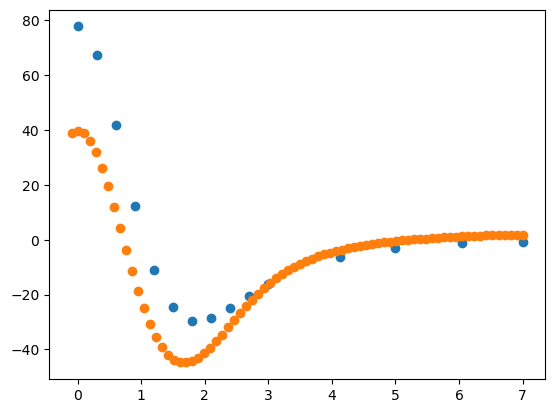

In [7]:
#Plot the curve
plt.plot(CCSDT[:,2],CCSDT_p,'o')
plt.plot(DFT[:,2],DFT[:,-1],'o')

In [8]:
#Make the training set by denoting CCSD(T) data with fidelity 1 (already done) and DFT with fidelity 0
train_x_HF = CCSDT[3:9,2][...,np.newaxis]
train_x_HF  = torch.from_numpy(train_x_HF)
train_x_LF = DFT[:,2][...,np.newaxis]
train_x_LF = torch.from_numpy(train_x_LF)


# Create fidelity indicator. 0 for LF, 1 for HF.
fidelity_LF = torch.zeros_like(train_x_LF)
fidelity_HF = torch.ones_like(train_x_HF)

# Concatenate inputs and fidelity indicators
train_x = torch.cat([
    torch.cat([train_x_LF, fidelity_LF], dim=1),
    torch.cat([train_x_HF, fidelity_HF], dim=1)
])

# Generate targets
train_y_LF = torch.from_numpy(DFT[:,-1][...,np.newaxis])
train_y_HF =torch.from_numpy(CCSDT_p[3:9][...,np.newaxis])
train_y = torch.cat([train_y_LF, train_y_HF])
train_yvar = torch.cat([1e-2*torch.ones_like(train_y_LF),1e-6*torch.ones_like(train_y_HF)])

In [9]:
# Create the multi-fidelity model and likelihood
model = SingleTaskMultiFidelityGP(train_x, train_y, train_yvar, data_fidelities=[len(train_x[0]) - 1], input_transform=Normalize(d=2),outcome_transform=Standardize(m=1))
modelvan = SingleTaskGP(train_X=train_x_HF, train_Y=train_y_HF, train_Yvar=1e-6*torch.ones_like(train_y_HF), input_transform=Normalize(d=1),outcome_transform=Standardize(m=1))

mll = ExactMarginalLogLikelihood(model.likelihood, model)
mllvan = ExactMarginalLogLikelihood(modelvan.likelihood, modelvan)
# Train the model hyperparameters
fit_gpytorch_mll(mll, optimizer_kwargs={"options": {"disp": 10}})
fit_gpytorch_mll(mllvan, optimizer_kwargs={"options": {"disp": True}})

/home/sutirthapaul/miniconda3/envs/benzene/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): SingleTaskGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)

In [10]:
# Generate test points
test_x_base = torch.linspace(0, 10, 300).unsqueeze(-1)

# Predict high-fidelity output
test_x_HF = torch.cat([test_x_base, torch.ones_like(test_x_base)], dim=1)
with torch.no_grad():
    posterior_HF = model.posterior(test_x_HF)
    mean_HF = posterior_HF.mean.cpu().detach().numpy()
    lower_HF, upper_HF = posterior_HF.confidence_region()
    lower_HF = (lower_HF.cpu().detach().numpy() - mean_HF.flatten())/2 + mean_HF.flatten()
    upper_HF = (upper_HF.cpu().detach().numpy() - mean_HF.flatten())/2 + mean_HF.flatten()

    
# Predict low-fidelity output
test_x_LF = torch.cat([test_x_base, torch.zeros_like(test_x_base)], dim=1)
with torch.no_grad():
    posterior_LF = model.posterior(test_x_LF)
    mean_LF = posterior_LF.mean.cpu().detach().numpy()
    lower_LF, upper_LF = posterior_LF.confidence_region()
    lower_LF = (lower_LF.cpu().detach().numpy() - mean_LF.flatten())/2 + mean_LF.flatten()
    upper_LF = (upper_LF.cpu().detach().numpy() - mean_LF.flatten())/2 + mean_LF.flatten()

# Predict vanilla-gp output
with torch.no_grad():
    posterior = modelvan.posterior(test_x_base)
    mean = posterior.mean.cpu().detach().numpy()
    lower, upper = posterior.confidence_region()
    lower = (lower.cpu().detach().numpy() - mean.flatten())/2 + mean.flatten()
    upper = (upper.cpu().detach().numpy() - mean.flatten())/2 + mean.flatten()

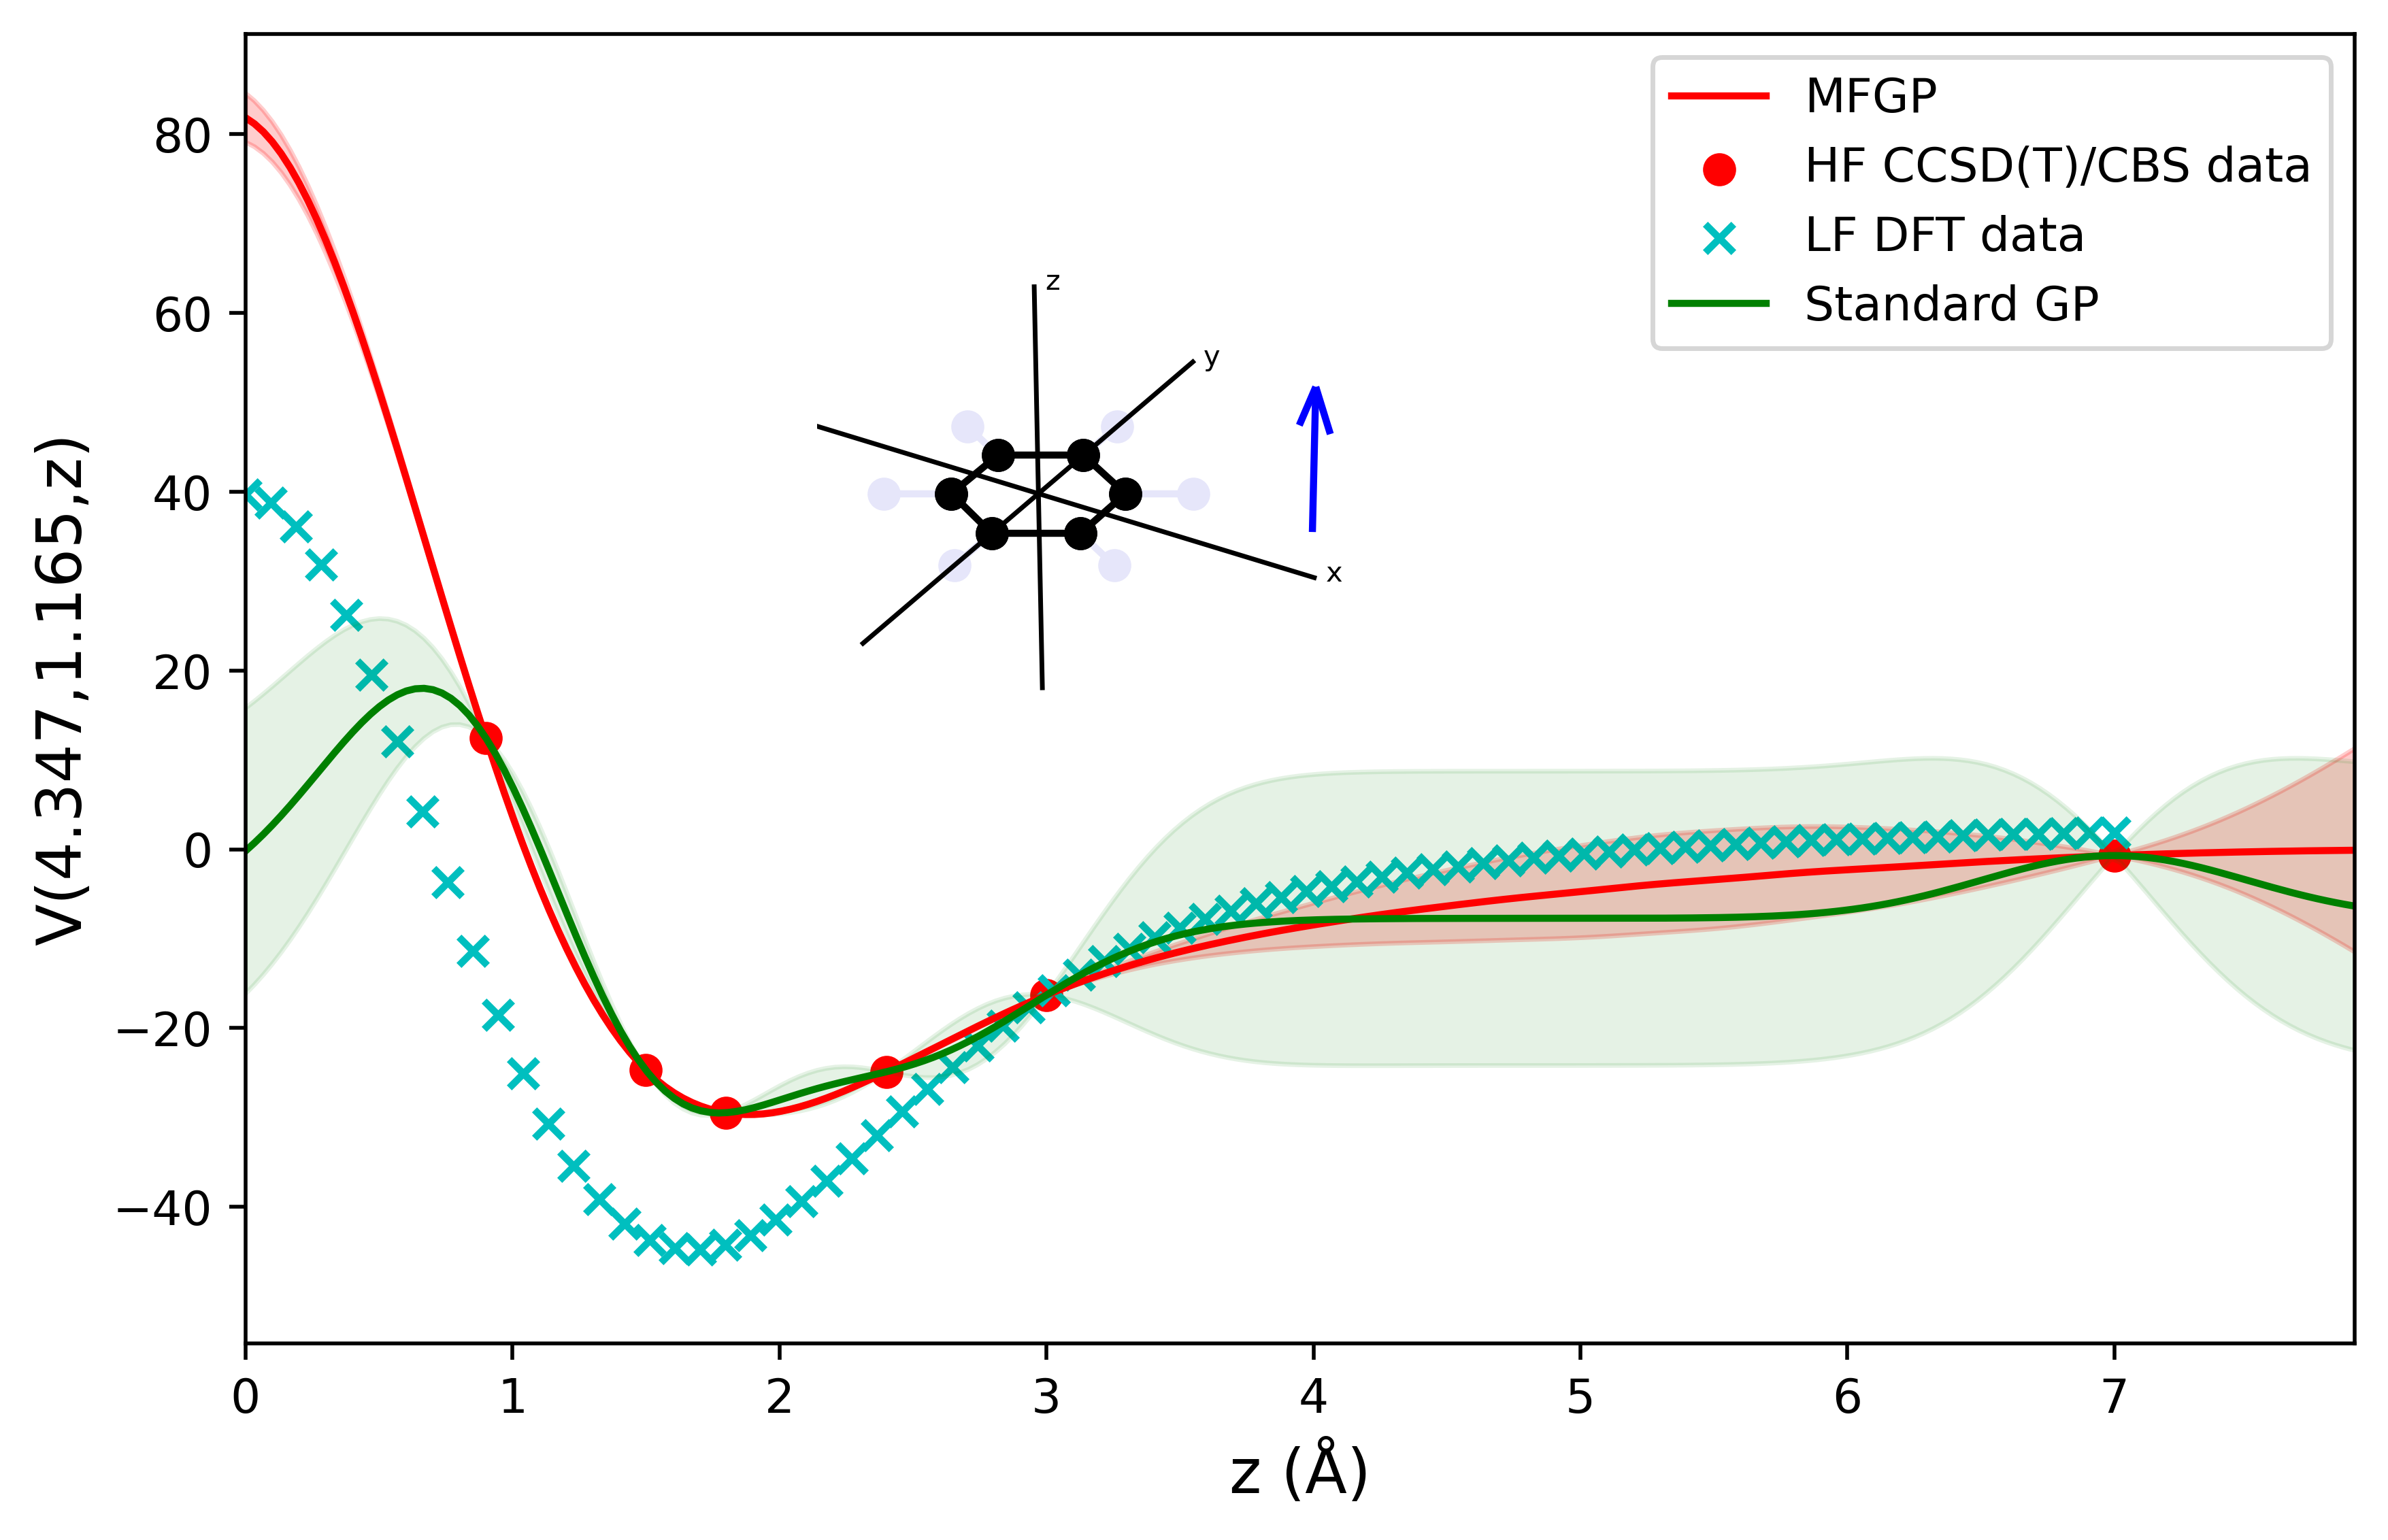

In [14]:
# Plot high-fidelity predictions
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.gcf().set_dpi(500)

ax.plot(test_x_base.cpu().numpy(), mean_HF, "r-", label="MFGP")
ax.fill_between(test_x_base.cpu().numpy().flatten(), lower_HF, upper_HF, color="r",alpha=0.2)
ax.scatter(train_x_HF.cpu().numpy(), train_y_HF.cpu().numpy(), c="r", marker="o", label="HF CCSD(T)/CBS data")
# Plot low-fidelity predictions
#ax.plot(test_x_base.cpu().numpy(), mean_LF, "c-", label="Predicted LF Mean")
#ax.fill_between(test_x_base.cpu().numpy().flatten(), lower_LF, upper_LF, alpha=0.3, label=r"LF $\sigma$")
ax.scatter(train_x_LF.cpu().numpy(), train_y_LF.cpu().numpy(), c="c", marker="x", label="LF DFT data")

#Plot vanilla predictions
ax.plot(test_x_base.cpu().numpy(), mean, "g-", label="Standard GP")
ax.fill_between(test_x_base.cpu().numpy().flatten(), lower.flatten(), upper.flatten(), color="g", alpha=0.1)
#ax.axhline(0,linestyle='--')

#ax.plot(test_x_base.cpu().numpy(),Shirkvec(test_x_base.cpu().numpy(),0,4.12)*0.695)
#ax.plot(test_x_base.cpu().numpy(),VVec(test_x_base.cpu().numpy(),0,4.12)*0.695)

# --- Create inset 3D axes ---
inset_ax = fig.add_axes([0.26, 0.45, 0.4, 0.4], projection='3d')
plot_benzene(inset_ax)
val = [5,0,0]
labels = ['x', 'y', 'z']
for v in range(3):
    xv = [val[v-0], -val[v-0]]
    yv = [val[v-1], -val[v-1]]
    zv = [val[v-2], -val[v-2]]
    inset_ax.plot(xv,yv,zv,'k-', linewidth=1)
    inset_ax.text(val[v-0]+0.2, val[v-1], val[v-2], labels[v], color='black', fontsize=6)


# Hide everything else
# make the panes transparent
#inset_ax.xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
#inset_ax.yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
#inset_ax.zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
# Hide box axes
inset_ax._axis3don = False
inset_ax.quiver(4.347,1.165, 0, 0, 0, 7, color='blue', length=0.5, arrow_length_ratio=0.3)
# Expand to remove white space
inset_ax.set_xlim(np.array([-2,5]))
inset_ax.set_ylim(np.array([-2,5]))
inset_ax.set_zlim(np.array([-2,5]))
#inset_ax.set_title("Inset 3D", fontsize=9)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_zticks([])

font_size = 13
plt.rc("font", size=10) 
ax.set_xlabel('z (Å)', size=font_size)
ax.set_ylabel('V(4.347,1.165,z)', size=font_size)
ax.legend()
ax.set_xlim(0,7.9)

plt.savefig('../figures/Multifiddemo.svg')